# EGGS Data

In [207]:
import os 
import datetime
import shapefile as shp
import seaborn as sns
import haversine as hs
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Import data and explore it

### SD6KS Surrounding Fields

In [2]:
# Create filepath for shapefile
fields_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Property Lines"
os.chdir(fields_fp)
fields = gpd.read_file('Fields_Around_SD6KS.shp')

In [3]:
# Get bounding coordinates
fields_coords = shp.Reader("Fields_Around_SD6KS.shp")
fields_coords.bbox

[-423875.3471000008, 1803101.1964999996, -362791.8465999998, 1854546.488500001]

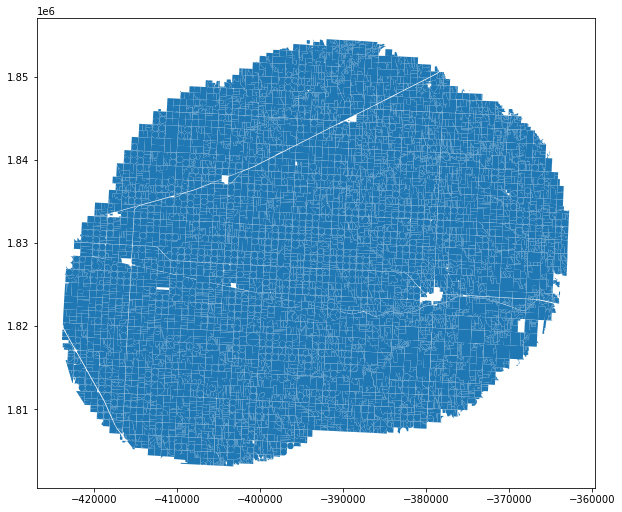

In [4]:
fig, ax = plt.subplots(figsize = (10,10))
fields.plot(ax=ax)
plt.show()

### SD6KS Boundary Shapefile

In [5]:
# Create filepath for shapefile
boundary_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Management Districts\\Kansas\\"
os.chdir(boundary_fp)
boundary = gpd.read_file('Boundary_SD6KS_BWilson_20220616.shp')

In [6]:
# Get bounding coordinates
boundary_coords = shp.Reader("Boundary_SD6KS_BWilson_20220616.shp")
boundary_coords.bbox

[346774.9221245285, 4352264.910569741, 375914.3972205508, 4371371.047506346]

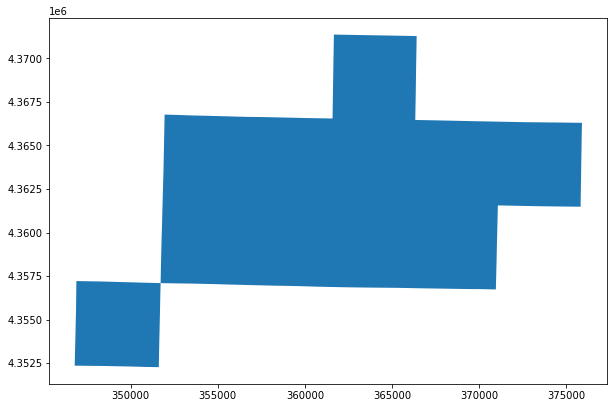

In [7]:
fig, ax = plt.subplots(figsize = (10,10))
boundary.plot(ax=ax)
plt.show()

### SD6KS Buffer Shapefile

In [8]:
# Create filepath for shapefile
buffer_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Management Districts\\Kansas\\"
os.chdir(buffer_fp)
buffer = gpd.read_file('BoundaryBuffer_SD6KS_BWilson_20220616.shp')

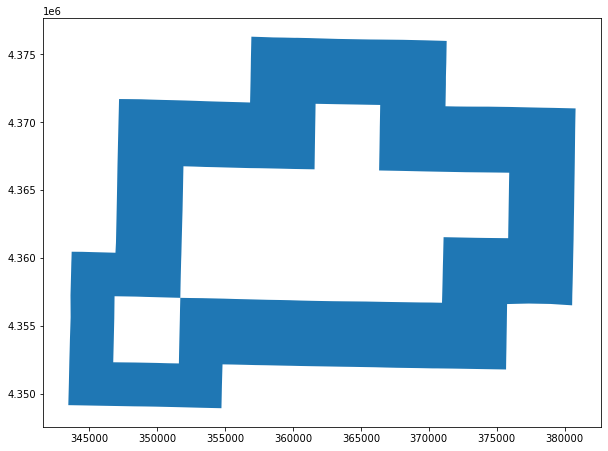

In [9]:
fig, ax = plt.subplots(figsize = (10,10))
buffer.plot(ax=ax)
plt.show()

### Overlaying Shapefiles

In [10]:
# Change to same CRS as SD6KS_Fields.shp so that layers can be added
boundary = boundary.to_crs(fields.crs)
buffer = buffer.to_crs(fields.crs)

<AxesSubplot:>

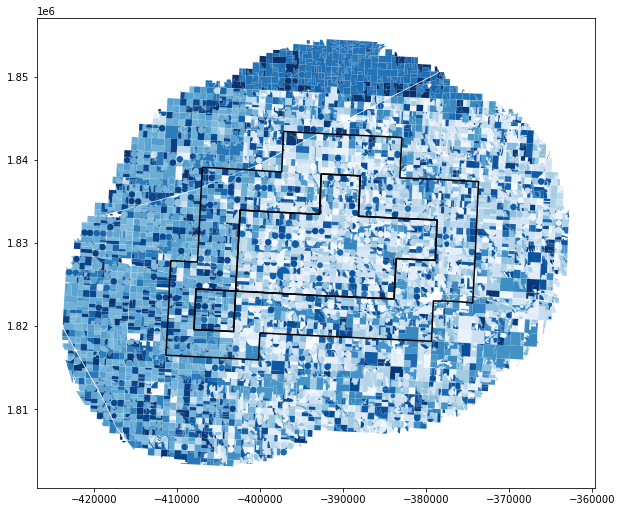

In [11]:
fig, ax = plt.subplots(figsize = (10,10))
base = fields.plot(cmap='Blues', ax=ax)
boundary.boundary.plot(ax=base, color='k')
buffer.boundary.plot(ax=base, color='k')

### OpenET Data (in, annually by field)

In [12]:
# Create a filepath for OpenET data and change working directory
openET_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Hydrometeorology\\OpenET\\"
os.chdir(openET_fp)

In [13]:
# Import ensemble file from OpenET
ensemble = pd.read_csv('ET_monthly_ensemble_FieldsAroundSD6KS_20220708.csv')
# Import DisALEXI file from OpenET
disalexi = pd.read_csv('ET_monthly_disalexi_FieldsAroundSD6KS_20220708.csv')
# Import eeMetric file from OpenET
eemetric = pd.read_csv('ET_monthly_eemetric_FieldsAroundSD6KS_20220708.csv')
# Import geeSEBAL file from OpenET
geesebal = pd.read_csv('ET_monthly_geesebal_FieldsAroundSD6KS_20220708.csv')
# Import PT-JPL file from OpenET
ptjpl = pd.read_csv('ET_monthly_ptjpl_FieldsAroundSD6KS_20220708.csv')
# Import SIMS file from OpenET
sims = pd.read_csv('ET_monthly_sims_FieldsAroundSD6KS_20220708.csv')
# Import SSEBop file from OpenET
ssebop = pd.read_csv('ET_monthly_ssebop_FieldsAroundSD6KS_20220708.csv')

In [14]:
# Create lists for the following for loop
et = [ensemble, disalexi, eemetric, geesebal, ptjpl, sims, ssebop]
lab = ['annual_ensemble', 'annual_disalexi', 'annual_eemetric', 'annual_geesebal', 'annual_ptjpl', 'annual_sims', 'annual_ssebop']

In [15]:
# Create a dictionary to store dataframes in
annual_et = {}

i = 0 # Used to set first index for lab

# Use a for loop to wrangle data from monthly into annual data (NOTE: WILL TAKE AWHILE TO RUN)
for x in et:
    x.drop('acres', inplace = True, axis = 1) # drop irrelevant columns
    merge_x = fields.merge(x, on = 'UID', how = 'left') # merge dataframes and shapefile together
    x_fields = gpd.GeoDataFrame(merge_x) # turn into geodataframe
    x_fields.time = pd.to_datetime(x_fields.time).dt.strftime('%Y') # change time column to datetime
    annual_et[lab[i]] = x_fields.dissolve(by = ['UID', 'time'], aggfunc = 'sum') # assign to dictionary, group by UID and time and sum the rest of the columns
    annual_et[lab[i]].drop('area', inplace = True, axis = 1) # drop irrelevant columns
    annual_et[lab[i]].reset_index(inplace=True) # ungroup from index format
    i += 1 # since index for lab was set to 0, this adds 1 to each iteration of for loop

In [16]:
# Turn into variables that are easier to call
annual_ensemble = annual_et['annual_ensemble']
annual_disalexi = annual_et['annual_disalexi']
annual_eemetric = annual_et['annual_eemetric']
annual_geesebal = annual_et['annual_geesebal']
annual_ptjpl = annual_et['annual_ptjpl']
annual_ssebop = annual_et['annual_ssebop']
annual_sims = annual_et['annual_sims']

### gridMET Data (mm, annual)

In [192]:
# Create gridMET filepath
gridmet_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Hydrometeorology\\gridMET\\"
os.chdir(gridmet_fp)

In [193]:
gridmet = pd.read_csv('DailyMet_FieldsAroundSD6KS_2016-2021_20220802.csv')

In [194]:
gridmet["date_ymd"] = pd.to_datetime(gridmet["date_ymd"], format='%Y%m%d')

In [195]:
gridmet.drop(['eto', 'etr'], inplace = True, axis = 1) # drop irrelevant columns

In [196]:
gridmet.date_ymd = pd.to_datetime(gridmet.date_ymd).dt.strftime('%Y')

In [197]:
annual_gridmet = gridmet.groupby(['UID','date_ymd'])['pr'].sum().reset_index()

In [198]:
annual_gridmet = fields.merge(annual_gridmet, on = 'UID', how = 'left')

In [199]:
annual_gridmet = gpd.GeoDataFrame(annual_gridmet)

In [200]:
annual_gridmet.drop('area', inplace = True, axis = 1) # drop irrelevant columns

In [201]:
annual_gridmet = annual_gridmet.rename({'date_ymd': 'time'}, axis=1)

### Irrigation Status (%, yearly)

In [26]:
# Create irrigation status filepath
aim_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Irrigation Status"
os.chdir(aim_fp)

In [27]:
aim = pd.read_csv('FieldsAttributes_FieldsAroundSD6KS_Irrigation_AnnualAIM.csv')
aim = aim[aim['Year'] > 2015]

In [28]:
# Merge dataframe with shapefile dataframe so that it can be plotted on a map
merge_aim = fields.merge(aim, on='UID', how='left')
aim_fields = gpd.GeoDataFrame(merge_aim)

### Annual CDL (yearly)

In [29]:
# Create annual CDL filepath
cdl_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Land Use-Land Cover"
os.chdir(cdl_fp)

In [30]:
cdl = pd.read_csv('FieldsAttributesAroundSD6KS_LandCover_AnnualCDL.csv')
cdl = cdl[cdl['Year'] > 2015]

In [31]:
# Merge dataframe with shapefile dataframe so that it can be plotted on a map
merge_cdl = fields.merge(cdl, on='UID', how='left')
cdl_fields = gpd.GeoDataFrame(merge_cdl)

In [32]:
cdl_fields.head(20)

,UID,area,geometry,Year,CropCode,pctcov
0,177799.0,600292.444252,"POLYGON ((-414437.581 1819101.031, -414495.592...",2016,1,0.980
1,177799.0,600292.444252,"POLYGON ((-414437.581 1819101.031, -414495.592...",2017,1,0.992
2,177799.0,600292.444252,"POLYGON ((-414437.581 1819101.031, -414495.592...",2018,1,0.951
3,177799.0,600292.444252,"POLYGON ((-414437.581 1819101.031, -414495.592...",2019,1,0.964
4,177799.0,600292.444252,"POLYGON ((-414437.581 1819101.031, -414495.592...",2020,1,0.972
5,177806.0,47681.447907,"POLYGON ((-414094.454 1817341.976, -414023.919...",2016,520,1.000
6,177806.0,47681.447907,"POLYGON ((-414094.454 1817341.976, -414023.919...",2017,520,1.000
7,177806.0,47681.447907,"POLYGON ((-414094.454 1817341.976, -414023.919...",2018,520,1.000
8,177806.0,47681.447907,"POLYGON ((-414094.454 1817341.976, -414023.919...",2019,520,1.000
9,177806.0,47681.447907,"POLYGON ((-414094.454 1817341.976, -414023.919...",2020,520,1.000


### Soil Data (by field)

In [33]:
# Create soil data filepath
soil_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Soils"
os.chdir(soil_fp)

In [34]:
soil = pd.read_csv('Soil_FieldsAroundSD6KS_POLARIS_AGrinstead_20220706.csv', index_col = 0)

In [35]:
# Merge dataframe with shapefile dataframe so that it can be plotted on a map
merge_soil = fields.merge(soil, on='UID', how='left')
soil_fields = gpd.GeoDataFrame(merge_soil)

In [36]:
soil_fields.head()

,UID,area,geometry,depth_cm,silt_prc,sand_prc,clay_prc,thetaS_m3m3,thetaR_m3m3,logKsat_cmHr,lambda,logHB_kPa,n,logAlpha_kPa1
0,177799.0,600292.444252,"POLYGON ((-414437.581 1819101.031, -414495.592...",0-5,50.40,27.29,18.87,0.49,0.06,0.07,0.32,0.32,1.36,-0.32
1,177799.0,600292.444252,"POLYGON ((-414437.581 1819101.031, -414495.592...",5-15,49.33,26.22,20.73,0.50,0.06,0.06,0.32,0.31,1.35,-0.30
2,177799.0,600292.444252,"POLYGON ((-414437.581 1819101.031, -414495.592...",15-30,48.84,21.45,25.32,0.51,0.06,-0.01,0.30,0.33,1.31,-0.32
3,177799.0,600292.444252,"POLYGON ((-414437.581 1819101.031, -414495.592...",30-60,50.74,18.06,26.88,0.52,0.07,-0.03,0.29,0.37,1.30,-0.36
4,177799.0,600292.444252,"POLYGON ((-414437.581 1819101.031, -414495.592...",60-100,52.26,20.64,21.70,0.50,0.06,0.04,0.31,0.37,1.32,-0.36


## Graph Making

### Creating annual mean ET subplots

In [37]:
# Create a list of strings to name the columns for ame
column_names = ['UID', 
           'time', 
           'geometry', 
           'ensemble_et_mean', 
           'disalexi_et_mean', 
           'eemetric_et_mean', 
           'geesebal_et_mean', 
           'ptjpl_et_mean', 
           'ssebop_et_mean', 
           'sims_et_mean']

# Create annual monthly ET dataframe by concatting columns from different ET algorithm data 
ame = gpd.GeoDataFrame(
pd.concat(
    [annual_ensemble['UID'],
     annual_ensemble['time'],
     annual_ensemble['geometry'],
     annual_ensemble['et_mean'],
     annual_disalexi['et_mean'],
     annual_eemetric['et_mean'],
     annual_geesebal['et_mean'],
     annual_ptjpl['et_mean'],
     annual_ssebop['et_mean'],
     annual_sims['et_mean']],
axis=1,
keys=column_names)
)

In [38]:
# Create a list for the following for loop made up of 
col = ['ensemble_et_mean', 
           'disalexi_et_mean', 
           'eemetric_et_mean', 
           'geesebal_et_mean', 
           'ptjpl_et_mean', 
           'ssebop_et_mean', 
           'sims_et_mean']

# Create a dictionary using a for loop to make a dataframe for each ET algorithm
annual_mean_et = dict()

for x in col:
    annual_mean_et[x] = gpd.GeoDataFrame(
pd.concat(
    [ame['UID'],
     ame['time'],
     ame['geometry'],
     ame[x]
    ],
    axis = 1,
    keys = ['UID', 
           'time', 
           'geometry', 
           str(x)])
)

In [39]:
# Create a dictionary using a for loop to merge dataframe
mean_et = dict()

for i in col:
    df = gpd.GeoDataFrame(annual_mean_et[i].pivot(index = 'UID', columns = 'time', values = str(i))) # make year data wider
    merging = fields.merge(df, on = 'UID', how = 'left') # merge with shapefile
    mean_et[i] = gpd.GeoDataFrame(merging) # merge with shapefile
    mean_et[i].drop('area', inplace=True, axis=1) # drop irrelevant columns

In [40]:
# Create variables easier to call
mean_ensemble = mean_et['ensemble_et_mean']
mean_disalexi = mean_et['disalexi_et_mean']
mean_eemetric = mean_et['eemetric_et_mean']
mean_geesebal = mean_et['geesebal_et_mean']
mean_ptjpl = mean_et['ptjpl_et_mean']
mean_ssebop = mean_et['ssebop_et_mean']
mean_sims = mean_et['sims_et_mean']

In [41]:
# Create lists that the figure can iterate through when plotting
years = ['2016', '2017', '2018', '2019', '2020', '2021']
mean_et_list = [mean_ensemble, mean_disalexi, mean_eemetric, mean_geesebal, mean_ptjpl, mean_ssebop, mean_sims]
ylab = ['Ensemble', 'DisALEXI', 'eeMetric', 'geeSEBAL', 'PT-JPL', 'SSEBop', 'SIMS']

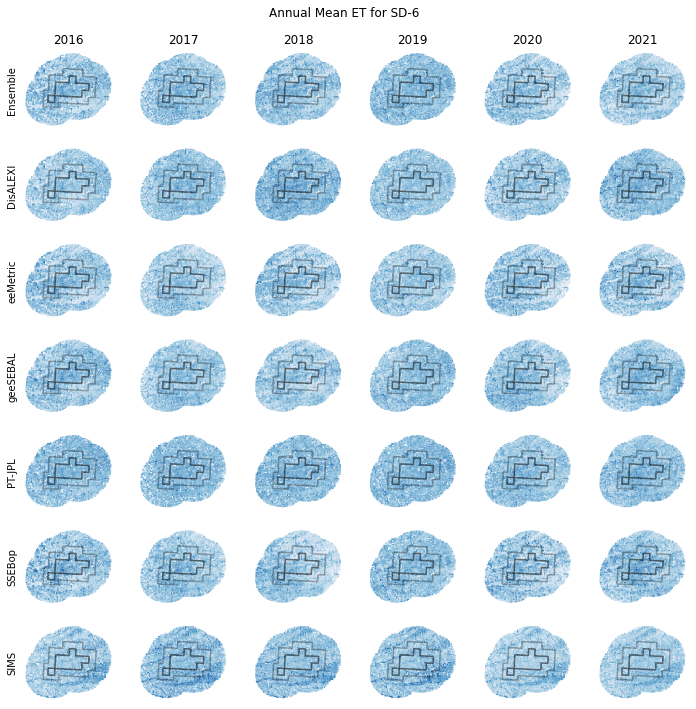

In [42]:
# Create figure and set axes
fig, axs = plt.subplots(nrows = 7, ncols = 6, figsize = (12, 12))
fig.suptitle('Annual Mean ET for SD-6', y=0.93)
fig.patch.set_facecolor('white')

# Create for loop to iterate through rows and columns
rows = 7
cols = 6
for r in range(rows):
    for c in range(cols):
        et = mean_et_list[r].plot(years[c], ax=axs[r,c], cmap='Blues')
        boundary.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        buffer.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        axs[r,c].patch.set_facecolor('white')
        axs[r,c].set_xticks([]) # remove tick marks 
        axs[r,c].set_xticklabels([]) # remove tick mark labels
        axs[r,c].set_yticks([])
        axs[r,c].set_yticklabels([])
        axs[r,c].spines['top'].set_visible(False) # remove border around plot
        axs[r,c].spines['right'].set_visible(False)
        axs[r,c].spines['bottom'].set_visible(False)
        axs[r,c].spines['left'].set_visible(False)
        if c == 0:
            axs[r,c].set_ylabel(ylab[r]) # set y-labels for first column
        if r == 0:
            axs[r,c].set_title(years[c]) # set year titles for each column

# fig.colorbar(cm.ScalarMappable(cmap='Blues'), ax=axs[r,c])

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\eggs\\')
plt.savefig('AnnualMeanETSD6.png', dpi=500)
plt.show()

### Annual Min ET 

In [43]:
# Create a list of strings to name the columns for ame
column_names = ['UID', 
           'time', 
           'geometry', 
           'ensemble_et_min', 
           'disalexi_et_min', 
           'eemetric_et_min', 
           'geesebal_et_min', 
           'ptjpl_et_min', 
           'ssebop_et_min', 
           'sims_et_min']

# Create annual monthly ET dataframe by concatting columns from different ET algorithm data 
ame1 = gpd.GeoDataFrame(
pd.concat(
    [annual_ensemble['UID'],
     annual_ensemble['time'],
     annual_ensemble['geometry'],
     annual_ensemble['et_min'],
     annual_disalexi['et_min'],
     annual_eemetric['et_min'],
     annual_geesebal['et_min'],
     annual_ptjpl['et_min'],
     annual_ssebop['et_min'],
     annual_sims['et_min']],
axis=1,
keys=column_names)
)

In [44]:
# Create a list for the following for loop made up of 
col = ['ensemble_et_min', 
           'disalexi_et_min', 
           'eemetric_et_min', 
           'geesebal_et_min', 
           'ptjpl_et_min', 
           'ssebop_et_min', 
           'sims_et_min']

# Create a dictionary using a for loop to make a dataframe for each ET algorithm
annual_min_et = dict()

for x in col:
    annual_min_et[x] = gpd.GeoDataFrame(
pd.concat(
    [ame1['UID'],
     ame1['time'],
     ame1['geometry'],
     ame1[x]
    ],
    axis = 1,
    keys = ['UID', 
           'time', 
           'geometry', 
           str(x)])
)

In [45]:
# Create a dictionary using a for loop to merge dataframe
min_et = dict()

for i in col:
    df1 = gpd.GeoDataFrame(annual_min_et[i].pivot(index = 'UID', columns = 'time', values = str(i))) # make year data wider
    merging = fields.merge(df1, on = 'UID', how = 'left') # merge with shapefile
    min_et[i] = gpd.GeoDataFrame(merging) # merge with shapefile
    min_et[i].drop('area', inplace=True, axis=1) # drop irrelevant columns

In [46]:
# Create variables easier to call
min_ensemble = min_et['ensemble_et_min']
min_disalexi = min_et['disalexi_et_min']
min_eemetric = min_et['eemetric_et_min']
min_geesebal = min_et['geesebal_et_min']
min_ptjpl = min_et['ptjpl_et_min']
min_ssebop = min_et['ssebop_et_min']
min_sims = min_et['sims_et_min']

In [47]:
# Create lists that the figure can iterate through when plotting
years = ['2016', '2017', '2018', '2019', '2020', '2021']
min_et_list = [min_ensemble, min_disalexi, min_eemetric, min_geesebal, min_ptjpl, min_ssebop, min_sims]
ylab = ['Ensemble', 'DisALEXI', 'eeMetric', 'geeSEBAL', 'PT-JPL', 'SSEBop', 'SIMS']

In [48]:
# # Create figure and set axes
# fig, axs = plt.subplots(nrows = 7, ncols = 6, figsize = (12, 12))

# # Create for loop to iterate through rows and columns
# rows = 7
# cols = 6
# for r in range(rows):
#     for c in range(cols):
#         et = min_et_list[r].plot(years[c], ax=axs[r,c], cmap='Blues')
#         boundary.plot(ax=axs[r,c], edgecolor='black', color='white', alpha=0.3)
#         buffer.plot(ax=axs[r,c], edgecolor='black', color='white', alpha=0.3)
#         axs[r,c].patch.set_facecolor('white')
#         axs[r,c].set_xticks([]) # remove tick marks 
#         axs[r,c].set_xticklabels([]) # remove tick mark labels
#         axs[r,c].set_yticks([])
#         axs[r,c].set_yticklabels([])
#         axs[r,c].spines['top'].set_visible(False) # remove border around plot
#         axs[r,c].spines['right'].set_visible(False)
#         axs[r,c].spines['bottom'].set_visible(False)
#         axs[r,c].spines['left'].set_visible(False)
#         if c == 0:
#             axs[r,c].set_ylabel(ylab[r]) # set y-labels for first column
#         if r == 0:
#             axs[r,c].set_title(years[c]) # set year titles for each column
# #         handles, labels = axs[r,c].get_legend_handles_labels()
# fig.legend(handles=axs[r,c], labels='ET (in)', loc='center right')
# fig.suptitle('Annual Min ET for SD-6', y=0.93)
# fig.patch.set_facecolor('white')
# # plt.legend((minz_et_list), ("ET"), loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
# #             bbox_transform = plt.gcf().transFigure )

# os.chdir('C:\\Users\\ashle\\Desktop\\KGS\eggs\\')
# plt.savefig('AnnualMinETSD6.png', dpi=500)
# plt.show()

### Annual Max ET

In [49]:
# Create a list of strings to name the columns for ame
column_names = ['UID', 
           'time', 
           'geometry', 
           'ensemble_et_max', 
           'disalexi_et_max', 
           'eemetric_et_max', 
           'geesebal_et_max', 
           'ptjpl_et_max', 
           'ssebop_et_max', 
           'sims_et_max']

# Create annual monthly ET dataframe by concatting columns from different ET algorithm data 
ame2 = gpd.GeoDataFrame(
pd.concat(
    [annual_ensemble['UID'],
     annual_ensemble['time'],
     annual_ensemble['geometry'],
     annual_ensemble['et_max'],
     annual_disalexi['et_max'],
     annual_eemetric['et_max'],
     annual_geesebal['et_max'],
     annual_ptjpl['et_max'],
     annual_ssebop['et_max'],
     annual_sims['et_max']],
axis=1,
keys=column_names)
)

In [50]:
# Create a list for the following for loop made up of 
col = ['ensemble_et_max', 
           'disalexi_et_max', 
           'eemetric_et_max', 
           'geesebal_et_max', 
           'ptjpl_et_max', 
           'ssebop_et_max', 
           'sims_et_max']

# Create a dictionary using a for loop to make a dataframe for each ET algorithm
annual_max_et = dict()

for x in col:
    annual_max_et[x] = gpd.GeoDataFrame(
pd.concat(
    [ame2['UID'],
     ame2['time'],
     ame2['geometry'],
     ame2[x]
    ],
    axis = 1,
    keys = ['UID', 
           'time', 
           'geometry', 
           str(x)])
)

In [51]:
# Create a dictionary using a for loop to merge dataframe
max_et = dict()

for i in col:
    df1 = gpd.GeoDataFrame(annual_max_et[i].pivot(index = 'UID', columns = 'time', values = str(i))) # make year data wider
    merging = fields.merge(df1, on = 'UID', how = 'left') # merge with shapefile
    max_et[i] = gpd.GeoDataFrame(merging) # merge with shapefile
    max_et[i].drop('area', inplace=True, axis=1) # drop irrelevant columns

In [52]:
# Create variables easier to call
max_ensemble = max_et['ensemble_et_max']
max_disalexi = max_et['disalexi_et_max']
max_eemetric = max_et['eemetric_et_max']
max_geesebal = max_et['geesebal_et_max']
max_ptjpl = max_et['ptjpl_et_max']
max_ssebop = max_et['ssebop_et_max']
max_sims = max_et['sims_et_max']

In [53]:
# Create lists that the figure can iterate through when plotting
years = ['2016', '2017', '2018', '2019', '2020', '2021']
max_et_list = [max_ensemble, max_disalexi, max_eemetric, max_geesebal, max_ptjpl, max_ssebop, max_sims]
ylab = ['Ensemble', 'DisALEXI', 'eeMetric', 'geeSEBAL', 'PT-JPL', 'SSEBop', 'SIMS']

In [54]:
# # Create figure and set axes
# fig, axs = plt.subplots(nrows = 7, ncols = 6, figsize = (12, 12))

# # Create for loop to iterate through rows and columns
# rows = 7
# cols = 6
# for r in range(rows):
#     for c in range(cols):
#         et = max_et_list[r].plot(years[c], ax=axs[r,c], cmap='Blues')
#         boundary.plot(ax=axs[r,c], edgecolor='black', color='white', alpha=0.3)
#         buffer.plot(ax=axs[r,c], edgecolor='black', color='white', alpha=0.3)
#         axs[r,c].patch.set_facecolor('white')
#         axs[r,c].set_xticks([]) # remove tick marks 
#         axs[r,c].set_xticklabels([]) # remove tick mark labels
#         axs[r,c].set_yticks([])
#         axs[r,c].set_yticklabels([])
#         axs[r,c].spines['top'].set_visible(False) # remove border around plot
#         axs[r,c].spines['right'].set_visible(False)
#         axs[r,c].spines['bottom'].set_visible(False)
#         axs[r,c].spines['left'].set_visible(False)
#         if c == 0:
#             axs[r,c].set_ylabel(ylab[r]) # set y-labels for first column
#         if r == 0:
#             axs[r,c].set_title(years[c]) # set year titles for each column
# #         handles, labels = axs[r,c].get_legend_handles_labels()
# fig.legend(handles=axs[r,c], labels='ET (in)', loc='center right')
# fig.suptitle('Annual max ET for SD-6', y=0.93)
# fig.patch.set_facecolor('white')
# # plt.legend((maxz_et_list), ("ET"), loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
# #             bbox_transform = plt.gcf().transFigure )

# os.chdir('C:\\Users\\ashle\\Desktop\\KGS\eggs\\')
# plt.savefig('AnnualmaxETSD6.png', dpi=500)
# plt.show()

### Annual Irrigated Fields for SD-6

In [55]:
aim_fields.drop('area', inplace=True, axis=1)

In [56]:
aim_pivot = gpd.GeoDataFrame(aim_fields.pivot(index = 'UID', columns = 'Year', values = 'IrrigatedPrc'))

In [57]:
aim_years = fields.merge(aim_pivot, on = 'UID', how = 'left') # merge with shapefile
aim_years = gpd.GeoDataFrame(aim_years) # merge with shapefile
aim_years.drop('area', inplace=True, axis=1)

In [58]:
aim_years.columns = aim_years.columns.astype(str)

In [59]:
# Create list that the figure can iterate through when plotting
years = ['2016', '2017', '2018', '2019', '2020']

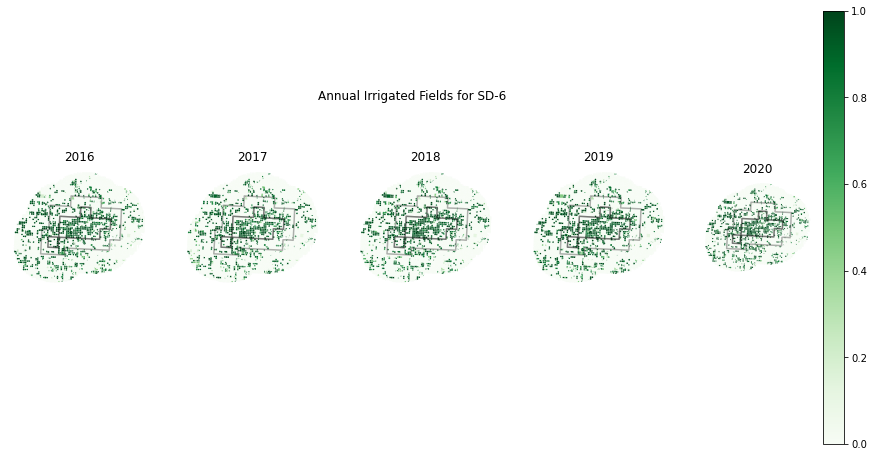

In [60]:
# Create figure and set axes
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (15, 15))
fig.suptitle('Annual Irrigated Fields for SD-6', y=0.63)
fig.patch.set_facecolor('white')

# Create for loop to iterate through rows and columns
rows = 1
cols = 5
for r in range(rows):
    for c in range(cols):
        y = years[c]
        aim = aim_years.plot(aim_years[y], ax=axs[c], cmap='Greens')
        boundary.boundary.plot(ax=axs[c], color='k', alpha=0.3)
        buffer.boundary.plot(ax=axs[c], color='k', alpha=0.3)
        axs[c].patch.set_facecolor('white')
        axs[c].set_xticks([]) # remove tick marks 
        axs[c].set_xticklabels([]) # remove tick mark labels
        axs[c].set_yticks([])
        axs[c].set_yticklabels([])
        axs[c].spines['top'].set_visible(False) # remove border around plot
        axs[c].spines['right'].set_visible(False)
        axs[c].spines['bottom'].set_visible(False)
        axs[c].spines['left'].set_visible(False)
        axs[c].set_title(y) # set year titles for each column

fig.colorbar(cm.ScalarMappable(cmap='Greens'), ax=axs[c])

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\eggs\\')
plt.savefig('AnnualIrrigatedFieldsSD6.png', dpi=500)
plt.show()

### Annual Crop Data

In [61]:
cdl.head(40)

,UID,Year,CropCode,pctcov
10,177799,2016,1,0.980
11,177799,2017,1,0.992
12,177799,2018,1,0.951
13,177799,2019,1,0.964
14,177799,2020,1,0.972
25,177806,2016,520,1.000
26,177806,2017,520,1.000
27,177806,2018,520,1.000
28,177806,2019,520,1.000
29,177806,2020,520,1.000


In [62]:
crop = cdl.copy()

In [63]:
crop.drop('pctcov', inplace=True, axis=1)

In [64]:
crop_pivot = gpd.GeoDataFrame(crop.pivot_table(index='UID', columns='Year', values='CropCode'))

In [65]:
crop_pivot.isnull().values.any()

False

In [66]:
crop_pivot.duplicated()

UID
177799     False
177806     False
178579      True
179074     False
179231     False
           ...  
1559408     True
1559409     True
1559410     True
1559411     True
1559412     True
Length: 11314, dtype: bool

In [67]:
crop_pivot

Year,2016,2017,2018,2019,2020
UID,,,,,
177799,1.0,1.0,1.0,1.0,1.0
177806,520.0,520.0,520.0,520.0,520.0
178579,520.0,520.0,520.0,520.0,520.0
179074,24.0,4.0,61.0,24.0,4.0
179231,24.0,1.0,61.0,24.0,1.0
...,...,...,...,...,...
1559408,61.0,24.0,61.0,24.0,4.0
1559409,1.0,1.0,1.0,1.0,1.0
1559410,1.0,1.0,1.0,5.0,1.0


In [68]:
cdl_fields.drop('area', inplace=True, axis=1)

In [69]:
cdl_pivot = gpd.GeoDataFrame(cdl_fields.pivot(index = ['UID', 'CropCode'], columns = 'Year', values = 'pctcov'))

In [70]:
cdl_pivot.reset_index(inplace=True)

In [71]:
cdl_pivot

Year,UID,CropCode,2016,2017,2018,2019,2020
0,177799.0,1,0.980,0.992,0.951,0.964,0.972
1,177806.0,520,1.000,1.000,1.000,1.000,1.000
2,178579.0,520,0.885,0.872,0.872,0.872,0.872
3,179074.0,4,NaN,0.886,NaN,NaN,0.845
4,179074.0,24,0.850,NaN,NaN,0.926,NaN
...,...,...,...,...,...,...,...
24463,1559410.0,5,NaN,NaN,NaN,0.896,NaN
24464,1559411.0,1,NaN,0.990,NaN,0.904,NaN
24465,1559411.0,5,0.773,NaN,0.868,NaN,0.576
24466,1559412.0,1,0.986,NaN,0.923,NaN,0.945


In [72]:
cdl_years = fields.merge(cdl_pivot, on = 'UID', how = 'left') # merge with shapefile
cdl_years = gpd.GeoDataFrame(cdl_years) # merge with shapefile
cdl_years.drop('area', inplace=True, axis=1)

In [73]:
cdl_years.columns = cdl_years.columns.astype(str)

In [74]:
cdl_years

,UID,geometry,CropCode,2016,2017,2018,2019,2020
0,177799.0,"POLYGON ((-414437.581 1819101.031, -414495.592...",1,0.980,0.992,0.951,0.964,0.972
1,177806.0,"POLYGON ((-414094.454 1817341.976, -414023.919...",520,1.000,1.000,1.000,1.000,1.000
2,178579.0,"POLYGON ((-405136.460 1804623.246, -405122.688...",520,0.885,0.872,0.872,0.872,0.872
3,179074.0,"POLYGON ((-404758.497 1804520.558, -404758.498...",4,NaN,0.886,NaN,NaN,0.845
4,179074.0,"POLYGON ((-404758.497 1804520.558, -404758.498...",24,0.850,NaN,NaN,0.926,NaN
...,...,...,...,...,...,...,...,...
24463,1559410.0,"POLYGON ((-396276.314 1848852.321, -396271.454...",5,NaN,NaN,NaN,0.896,NaN
24464,1559411.0,"POLYGON ((-395767.923 1849882.961, -395656.172...",1,NaN,0.990,NaN,0.904,NaN
24465,1559411.0,"POLYGON ((-395767.923 1849882.961, -395656.172...",5,0.773,NaN,0.868,NaN,0.576
24466,1559412.0,"POLYGON ((-395794.257 1849884.306, -395834.930...",1,0.986,NaN,0.923,NaN,0.945


In [75]:
# Create list that the figure can iterate through when plotting
years = ['2016', '2017', '2018', '2019', '2020']

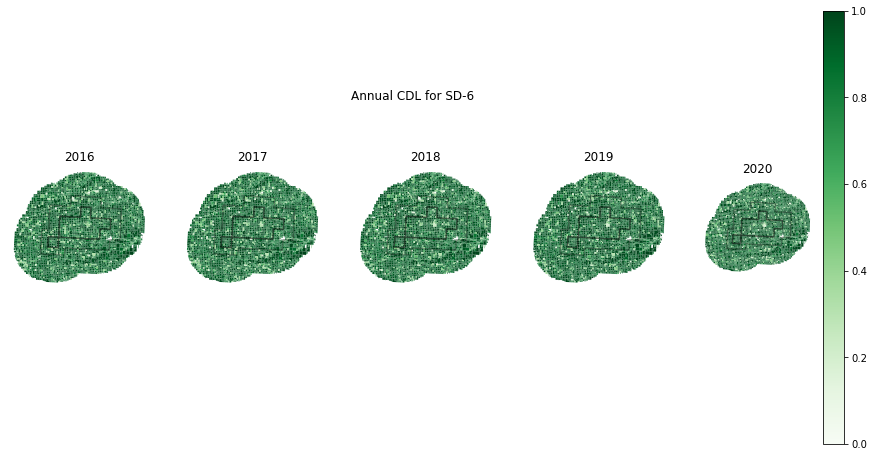

In [76]:
# Create figure and set axes
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (15, 15))
fig.suptitle('Annual CDL for SD-6', y=0.63)
fig.patch.set_facecolor('white')

# Create for loop to iterate through rows and columns
rows = 1
cols = 5
for r in range(rows):
    for c in range(cols):
        y = years[c]
        cdl = cdl_years.plot(cdl_years[y], ax=axs[c], cmap='Greens')
        boundary.boundary.plot(ax=axs[c], color='k', alpha=0.3)
        buffer.boundary.plot(ax=axs[c], color='k', alpha=0.3)
        axs[c].patch.set_facecolor('white')
        axs[c].set_xticks([]) # remove tick marks 
        axs[c].set_xticklabels([]) # remove tick mark labels
        axs[c].set_yticks([])
        axs[c].set_yticklabels([])
        axs[c].spines['top'].set_visible(False) # remove border around plot
        axs[c].spines['right'].set_visible(False)
        axs[c].spines['bottom'].set_visible(False)
        axs[c].spines['left'].set_visible(False)
        axs[c].set_title(y) # set year titles for each column

fig.colorbar(cm.ScalarMappable(cmap='Greens'), ax=axs[c])

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\eggs\\')
plt.savefig('AnnualCDLSD6.png', dpi=500)
plt.show()

### Irrigation (mean) = ET (mean) - P (mean) Dataset

In [202]:
# Pivot dataset so that the columns represent the years and the values are the precip
gridmet_pivot = gpd.GeoDataFrame(annual_gridmet.pivot(index = 'UID', columns = 'time', values = 'pr'))
gridmet_pivot.reset_index(inplace = True) # reset the index
gridmet_pivot.columns = gridmet_pivot.columns.astype(str) # change column types to strings

In [203]:
# Select relevant columns
gridmet_pivot = gridmet_pivot[['UID', '2016', '2017', '2018', '2019', '2020', '2021']]

In [205]:
# Check for NaN values
gridmet_null = gridmet_pivot[gridmet_pivot.isna().any(axis=1)] # there are 4148 rows that are NaN

In [210]:
# create new dataframe for values that don't have gridmet_null in them
gridmet_val = gridmet_pivot.dropna()

In [213]:
# find haversine distance between
for i in range(0, len(df_one.index)):
    for j in range(0, len(df_one.columns)):
        print(df_one.values[i,j],df_two.values[i,j],i,j)

for UID in [gridmet_null, gridmet_val]:
    hs.haversine(UID, UID)

ValueError: too many values to unpack (expected 2)

In [169]:
# UNCERTAINTY
# Fill the NaN values with the mean precip for each year
gridmet_pivot['2016'].fillna((gridmet_pivot['2016'].mean()), inplace=True)
gridmet_pivot['2017'].fillna((gridmet_pivot['2017'].mean()), inplace=True)
gridmet_pivot['2018'].fillna((gridmet_pivot['2018'].mean()), inplace=True)
gridmet_pivot['2019'].fillna((gridmet_pivot['2019'].mean()), inplace=True)
gridmet_pivot['2020'].fillna((gridmet_pivot['2020'].mean()), inplace=True)
gridmet_pivot['2021'].fillna((gridmet_pivot['2021'].mean()), inplace=True)

In [170]:
mean_precip = fields.merge(gridmet_pivot, on = 'UID', how = 'left') # merge with shapefile
mean_precip = gpd.GeoDataFrame(mean_precip) # merge with shapefile
mean_precip.drop('area', inplace=True, axis=1)

In [171]:
mean_precip = mean_precip[['2016', '2017', '2018', '2019', '2020', '2021']]

In [172]:
mean_ens = mean_ensemble[['2016', '2017', '2018', '2019', '2020', '2021']]

In [173]:
mean_irrigation = mean_ens.subtract(mean_precip)

In [174]:
mean_irrigation.columns = mean_irrigation.columns.astype(str)

In [175]:
irr_col = ['UID', 'geometry', '2016', '2017', '2018', '2019', '2020', '2021']
mean_irrigation = gpd.GeoDataFrame(
pd.concat([mean_ensemble['UID'],
           mean_ensemble['geometry'],
           mean_irrigation['2016'],
           mean_irrigation['2017'],
           mean_irrigation['2018'],
           mean_irrigation['2019'],
           mean_irrigation['2020'],
           mean_irrigation['2021']], 
          axis=1,
          keys=irr_col
         )
)

In [176]:
mean_irrigation

,UID,geometry,2016,2017,2018,2019,2020,2021
0,177799.0,"POLYGON ((-414437.581 1819101.031, -414495.592...",305.435000,7.220000,16.285000,1.536000,374.983000,32.431000
1,177806.0,"POLYGON ((-414094.454 1817341.976, -414023.919...",8.822967,-96.136576,-53.796861,-94.167317,225.350858,-18.389521
2,178579.0,"POLYGON ((-405136.460 1804623.246, -405122.688...",196.668967,95.577424,97.507139,-3.270317,487.936858,96.997479
3,179074.0,"POLYGON ((-404758.497 1804520.558, -404758.498...",274.045000,15.668000,-58.947000,199.600000,382.754000,-4.063000
4,179231.0,"POLYGON ((-412878.364 1818198.737, -412915.779...",420.268000,40.513000,-157.363000,152.838000,463.185000,130.142000
...,...,...,...,...,...,...,...,...
11309,1559408.0,"POLYGON ((-396625.379 1849926.768, -396823.900...",55.934000,162.795000,48.672000,-21.776000,433.170000,85.757000
11310,1559409.0,"POLYGON ((-396515.356 1849921.148, -396342.777...",346.319000,185.027000,250.451000,48.116000,586.175000,355.362000
11311,1559410.0,"POLYGON ((-396276.314 1848852.321, -396271.454...",319.474000,186.740000,288.004000,-36.269000,589.377000,372.922000
11312,1559411.0,"POLYGON ((-395767.923 1849882.961, -395656.172...",317.486000,164.930000,227.234000,79.102000,522.829000,349.205000
